# Reproducing Figure 1B: Phase Diagram of Condensate Dynamics

This notebook reproduces Figure 1B from Goh et al. (2025), showing the four dynamical regimes of transcriptional condensates responding to RNA gradients.

## The Four Regimes

- **Regime I (Dissolution):** Droplet dissolves due to insufficient protein
- **Regime II (Renucleation):** Droplet dissolves then reforms at the promoter
- **Regime III (Directed Motion):** Droplet flows toward the RNA source
- **Regime IV (Elongation):** Motion accompanied by shape deformation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
from pathlib import Path

# Add source directory
sys.path.insert(0, str(Path('../src/phasefield').resolve()))

from config import SimulationConfig
from solvers.coupled_solver import CoupledSolver, classify_regime

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
print("Imports successful!")

Imports successful!


## Part 1: Run Single Simulations for Each Regime

In [ ]:
def run_regime_simulation(regime, t_final=300.0, verbose=True):
    """
    Run a simulation for a specific regime from Figure 1B.
    """
    # Get preset configuration
    if regime == 'I':
        config = SimulationConfig.figure_1b_regime_i()
    elif regime == 'II':
        config = SimulationConfig.figure_1b_regime_ii()
    elif regime == 'III':
        config = SimulationConfig.figure_1b_regime_iii()
    elif regime == 'IV':
        config = SimulationConfig.figure_1b_regime_iv()
    else:
        raise ValueError(f"Unknown regime: {regime}")
    
    # Set simulation parameters
    config.numerical.t_final = t_final
    config.numerical.dt = 0.0002  # Small for stability
    config.numerical.save_interval = 500
    
    if verbose:
        print(f"Running Regime {regime}:")
        print(f"  k_p = {config.transport.k_p}")
        print(f"  c-(0) = {config.initial.c_minus_init}")
    
    # Run simulation
    solver = CoupledSolver(config)
    solver.initialize()
    history = solver.run()
    
    return history, solver, config

In [3]:
# Run Regime III as a test (directed motion)
print("Testing with Regime III (directed motion)...")
history_iii, solver_iii, config_iii = run_regime_simulation('III', t_final=100.0)

Testing with Regime III (directed motion)...
Running Regime III:
  k_p = 0.08
  c-(0) = 3.53
Running simulation: 500000 steps, dt=0.0002, t_final=100.0
  Step 500/500000 (t=0.10), ETA: 133.5s, droplet r=10.21
  Step 1000/500000 (t=0.20), ETA: 135.3s, droplet r=11.02
  Step 1500/500000 (t=0.30), ETA: 136.5s, droplet r=11.35
  Step 2000/500000 (t=0.40), ETA: 136.0s, droplet r=11.52
  Step 2500/500000 (t=0.50), ETA: 135.6s, droplet r=11.61
  Step 3000/500000 (t=0.60), ETA: 135.6s, droplet r=11.65
  Step 3500/500000 (t=0.70), ETA: 136.4s, droplet r=11.69
  Step 4000/500000 (t=0.80), ETA: 136.3s, droplet r=11.71
  Step 4500/500000 (t=0.90), ETA: 135.8s, droplet r=11.71
  Step 5000/500000 (t=1.00), ETA: 135.4s, droplet r=11.73
  Step 5500/500000 (t=1.10), ETA: 135.0s, droplet r=11.73
  Step 6000/500000 (t=1.20), ETA: 134.8s, droplet r=11.73
  Step 6500/500000 (t=1.30), ETA: 134.8s, droplet r=11.72
  Step 7000/500000 (t=1.40), ETA: 134.5s, droplet r=11.72
  Step 7500/500000 (t=1.50), ETA: 134

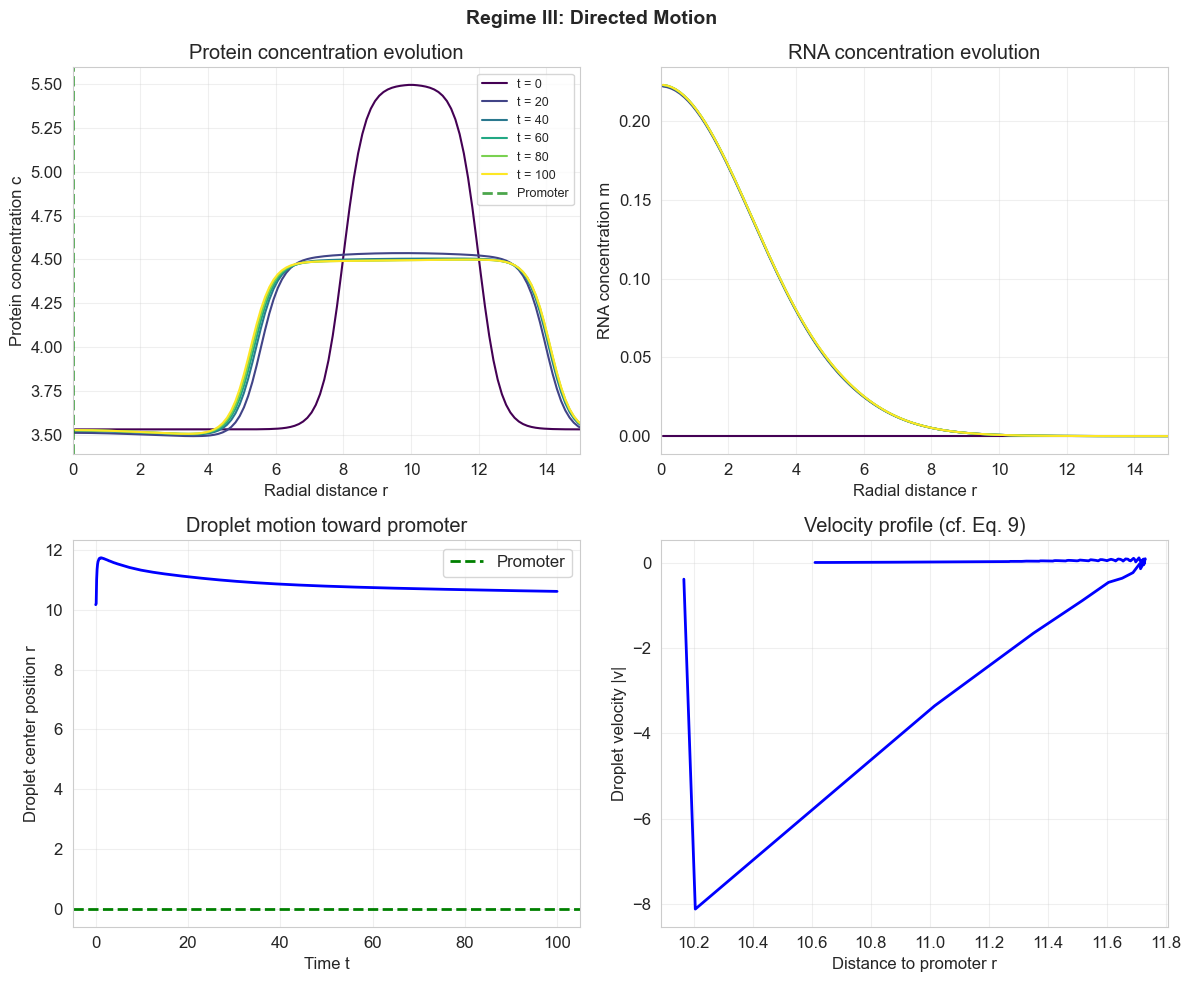


Classified regime: unknown


In [4]:
# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Panel A: Concentration profiles over time
ax = axes[0, 0]
n_profiles = min(6, len(history_iii))
indices = np.linspace(0, len(history_iii)-1, n_profiles, dtype=int)
colors = cm.viridis(np.linspace(0, 1, n_profiles))

for i, idx in enumerate(indices):
    state = history_iii[idx]
    ax.plot(solver_iii.grid.r_centers, state.c, color=colors[i], 
            label=f't = {state.t:.0f}', linewidth=1.5)

ax.axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Promoter')
ax.set_xlabel('Radial distance r')
ax.set_ylabel('Protein concentration c')
ax.set_title('Protein concentration evolution')
ax.legend(loc='upper right', fontsize=9)
ax.set_xlim(0, 15)
ax.grid(True, alpha=0.3)

# Panel B: RNA profiles
ax = axes[0, 1]
for i, idx in enumerate(indices):
    state = history_iii[idx]
    ax.plot(solver_iii.grid.r_centers, state.m, color=colors[i], linewidth=1.5)

ax.set_xlabel('Radial distance r')
ax.set_ylabel('RNA concentration m')
ax.set_title('RNA concentration evolution')
ax.set_xlim(0, 15)
ax.grid(True, alpha=0.3)

# Panel C: Droplet position vs time
ax = axes[1, 0]
times = [s.t for s in history_iii if s.droplet_center is not None]
positions = [s.droplet_center for s in history_iii if s.droplet_center is not None]
ax.plot(times, positions, 'b-', linewidth=2)
ax.axhline(0, color='green', linestyle='--', linewidth=2, label='Promoter')
ax.set_xlabel('Time t')
ax.set_ylabel('Droplet center position r')
ax.set_title('Droplet motion toward promoter')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel D: Velocity vs distance
ax = axes[1, 1]
if len(times) > 1:
    velocities = -np.diff(positions) / np.diff(times)
    ax.plot(positions[:-1], velocities, 'b-', linewidth=2)
    ax.set_xlabel('Distance to promoter r')
    ax.set_ylabel('Droplet velocity |v|')
    ax.set_title('Velocity profile (cf. Eq. 9)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Regime III: Directed Motion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classify the result
regime = classify_regime(history_iii, config_iii)
print(f"\nClassified regime: {regime}")

## Part 2: Parameter Sweep to Generate Phase Diagram

To reproduce Figure 1B, we need to sweep over the parameter space (k_p, c_minus_init) and classify each simulation.

In [2]:
def run_parameter_sweep(k_p_values, c_minus_values, t_final=200.0):
    """
    Run simulations across parameter space and classify regimes.
    
    WARNING: This can take a long time! Start with coarse grids.
    """
    results = []
    
    total = len(k_p_values) * len(c_minus_values)
    count = 0
    
    for k_p in k_p_values:
        for c_minus in c_minus_values:
            count += 1
            print(f"Running {count}/{total}: k_p={k_p:.3f}, c-={c_minus:.3f}...", end=' ')
            
            try:
                # Create configuration
                config = SimulationConfig()
                config.transport.k_p = k_p
                config.initial.c_minus_init = c_minus
                config.numerical.t_final = t_final
                config.numerical.dt = 0.0002
                config.numerical.save_interval = 1000
                
                # Run simulation
                solver = CoupledSolver(config)
                solver.initialize()
                history = solver.run()
                
                # Classify result
                regime = classify_regime(history, config)
                
                # Get final state
                final = history[-1]
                
                results.append({
                    'k_p': k_p,
                    'c_minus': c_minus,
                    'regime': regime,
                    'final_position': final.droplet_center,
                    'final_radius': final.droplet_radius
                })
                
                print(f"Regime {regime}")
                
            except Exception as e:
                print(f"Error: {e}")
                results.append({
                    'k_p': k_p,
                    'c_minus': c_minus,
                    'regime': 'error',
                    'final_position': None,
                    'final_radius': None
                })
    
    return results

print("Parameter sweep function defined.")
print("\nTo run the full sweep (takes a long time):")
print("  k_p_values = np.linspace(0.025, 0.5, 10)")
print("  c_minus_values = np.linspace(3.51, 3.63, 10)")
print("  results = run_parameter_sweep(k_p_values, c_minus_values)")

Parameter sweep function defined.

To run the full sweep (takes a long time):
  k_p_values = np.linspace(0.025, 0.5, 10)
  c_minus_values = np.linspace(3.51, 3.63, 10)
  results = run_parameter_sweep(k_p_values, c_minus_values)


In [4]:
# Run a small test sweep (3x3 grid)
print("Running test sweep with 3x3 grid...")
k_p_test = [0.05, 0.15, 0.4]
c_minus_test = [3.51, 3.55, 3.60]

# This will take a few minutes
test_results = run_parameter_sweep(k_p_test, c_minus_test, t_final=100.0)

Running test sweep with 3x3 grid...
Running 1/9: k_p=0.050, c-=3.510... Running simulation: 500000 steps, dt=0.0002, t_final=100.0
  Step 1000/500000 (t=0.20), ETA: 136.9s, droplet r=10.93
  Step 2000/500000 (t=0.40), ETA: 136.7s, droplet r=11.42
  Step 3000/500000 (t=0.60), ETA: 136.8s, droplet r=11.54
  Step 4000/500000 (t=0.80), ETA: 136.8s, droplet r=11.59
  Step 5000/500000 (t=1.00), ETA: 137.5s, droplet r=11.60
  Step 6000/500000 (t=1.20), ETA: 137.2s, droplet r=11.59
  Step 7000/500000 (t=1.40), ETA: 136.6s, droplet r=11.58
  Step 8000/500000 (t=1.60), ETA: 136.1s, droplet r=11.56
  Step 9000/500000 (t=1.80), ETA: 135.6s, droplet r=11.54
  Step 10000/500000 (t=2.00), ETA: 135.3s, droplet r=11.53
  Step 11000/500000 (t=2.20), ETA: 135.0s, droplet r=11.51
  Step 12000/500000 (t=2.40), ETA: 134.6s, droplet r=11.49
  Step 13000/500000 (t=2.60), ETA: 134.2s, droplet r=11.48
  Step 14000/500000 (t=2.80), ETA: 133.7s, droplet r=11.46
  Step 15000/500000 (t=3.00), ETA: 133.6s, droplet r


Test sweep results:
 k_p  c_minus regime  final_position  final_radius
0.05     3.51      I       10.436478        4.1875
0.05     3.55    III       11.015122        4.5625
0.05     3.60    III       11.627403        4.9375
0.15     3.51    III       10.255717        4.1875
0.15     3.55    III       10.707670        4.5625
0.15     3.60    III       11.278258        5.0000
0.40     3.51     II        9.949764        6.8125
0.40     3.55     II       10.423163        7.0625
0.40     3.60     II       10.977432        7.3125


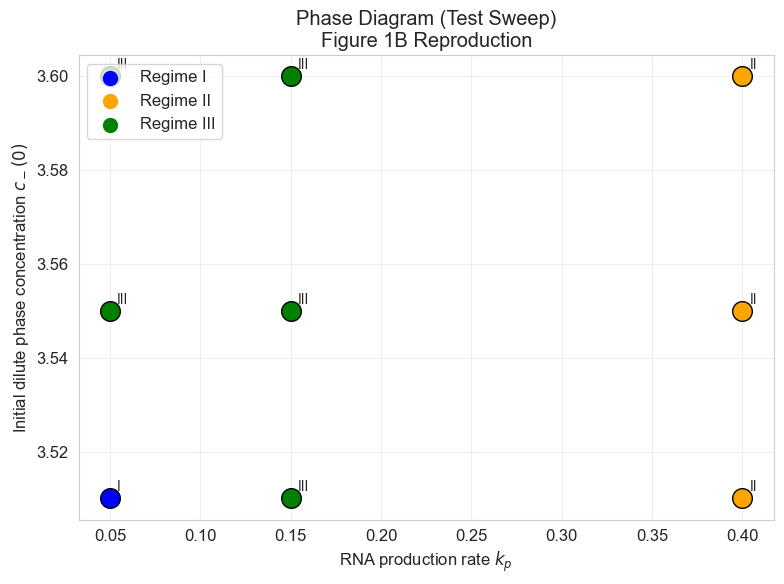

In [5]:
# Visualize the test results
import pandas as pd

df = pd.DataFrame(test_results)
print("\nTest sweep results:")
print(df.to_string(index=False))

# Create a simple phase diagram
regime_colors = {'I': 'blue', 'II': 'orange', 'III': 'green', 'IV': 'red', 'unknown': 'gray', 'error': 'black'}

fig, ax = plt.subplots(figsize=(8, 6))

for _, row in df.iterrows():
    color = regime_colors.get(row['regime'], 'gray')
    ax.scatter(row['k_p'], row['c_minus'], c=color, s=200, edgecolors='black', linewidth=1)
    ax.annotate(row['regime'], (row['k_p'], row['c_minus']), 
                textcoords="offset points", xytext=(5,5), fontsize=10)

ax.set_xlabel('RNA production rate $k_p$')
ax.set_ylabel('Initial dilute phase concentration $c_-(0)$')
ax.set_title('Phase Diagram (Test Sweep)\nFigure 1B Reproduction')

# Add legend
for regime, color in regime_colors.items():
    if regime in df['regime'].values:
        ax.scatter([], [], c=color, s=100, label=f'Regime {regime}')
ax.legend(loc='upper left')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 3: Compare with Paper Figure

To fully reproduce Figure 1B:

1. Run a finer parameter sweep (at least 20x20 grid)
2. Run longer simulations (t_final = 500 or more)
3. Carefully classify each regime
4. Draw phase boundaries

**Expected result:** You should see:
- Regime I at low c_minus (insufficient protein)
- Regime II at high k_p, low c_minus (renucleation)
- Regime III at moderate parameters (directed motion)
- Regime IV at higher c_minus (elongation)

In [8]:
print("="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print("""
Next steps to fully reproduce Figure 1B:

1. Increase grid resolution: k_p_values = np.linspace(0.025, 0.5, 20)
2. Increase simulation time: t_final = 500
3. Run on a cluster (each point takes ~5-10 minutes)
4. Compare phase boundaries with the paper

For the experimental validation, see: experimental_analysis.ipynb
""")

NOTEBOOK COMPLETE

Next steps to fully reproduce Figure 1B:

1. Increase grid resolution: k_p_values = np.linspace(0.025, 0.5, 20)
2. Increase simulation time: t_final = 500
3. Run on a cluster (each point takes ~5-10 minutes)
4. Compare phase boundaries with the paper

For the experimental validation, see: experimental_analysis.ipynb

